In [4]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

## LOADING DATA

In [5]:
#Loading the Pokemon dataset I got off Kaggle.
data = pd.read_csv("Pokemon.csv")
print("Number of datapoints:", len(data))
data.head(20)

Number of datapoints: 800


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
5,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False
9,7,Squirtle,Water,NaN,314,44,48,65,50,64,43,1,False


## DATA CLEANING

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


Here I dropped the Type 2 column as it will be made redundant by the feature engineering part below
and me making a feature called "Group Type."

In [7]:
data.drop("Type 2", axis=1)
data = data.drop("Type 2", axis=1)
display(data)

,#,Name,Type 1,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,680,80,160,60,170,130,80,6,True


## Feature Engineering
Here I combined Pokemon's attacking and defensive stats into one group of each, and made 5 groups out of 18 types of Pokemon.

In [8]:
data['Total Attacking Stats'] = (data['Attack'] + data['Sp. Atk'] + data['Speed'])
data['Total Defensive Stats'] = (data['HP'] + data['Defense'] + data['Sp. Def'])
data['Defensive/Offensive'] = data.apply(lambda row: 'Defensive' if row['Total Defensive Stats'] > row['Total Attacking Stats'] else ('Offensive' if row['Total Attacking Stats'] > row['Total Defensive Stats'] else 'Neutral'), axis=1)
# Assign labels to each group
labels = {
    'Elemental': ['Fire', 'Water', 'Grass', 'Electric', 'Ice'],
    'Physical Combat/Normal': ['Normal', 'Fighting', 'Ground', 'Rock', 'Steel'],
    'Mysterious or Psychic': ['Ghost', 'Dark', 'Psychic'],
    'Mythical Beings': ['Dragon', 'Fairy'],
    'Venomous Fliers': ['Flying', 'Bug', 'Poison']
}

# Define a function to assign labels based on type
def assign_label(type_name):
    for label, types in labels.items():
        if type_name in types:
            return label
    return 'Other'

# Add a new column to the dataframe with the group type labels
data['Group Type'] = data['Type 1'].apply(assign_label)

#Dropping some of the redundant features because there are very few Legendary pokemons.
to_drop = ["Legendary"]
data = data.drop(to_drop, axis=1) 
display(data)
print(data['Group Type'].count())
data.to_csv("pokemon_2.csv")

,#,Name,Type 1,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Total Attacking Stats,Total Defensive Stats,Defensive/Offensive,Group Type
0,1,Bulbasaur,Grass,318,45,49,49,65,65,45,1,159,159,Neutral,Elemental
1,2,Ivysaur,Grass,405,60,62,63,80,80,60,1,202,203,Defensive,Elemental
2,3,Venusaur,Grass,525,80,82,83,100,100,80,1,262,263,Defensive,Elemental
3,3,VenusaurMega Venusaur,Grass,625,80,100,123,122,120,80,1,302,323,Defensive,Elemental
4,4,Charmander,Fire,309,39,52,43,60,50,65,1,177,132,Offensive,Elemental
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,600,50,100,150,100,150,50,6,250,350,Defensive,Physical Combat/Normal
796,719,DiancieMega Diancie,Rock,700,50,160,110,160,110,110,6,430,270,Offensive,Physical Combat/Normal
797,720,HoopaHoopa Confined,Psychic,600,80,110,60,150,130,70,6,330,270,Offensive,Mysterious or Psychic
798,720,HoopaHoopa Unbound,Psychic,680,80,160,60,170,130,80,6,410,270,Offensive,Mysterious or Psychic


800


## Explanation of the columns' titles

I got the "official" definitions, for terms which could be "officially" defined, from the Pokemon Wiki.

HP is a value that determines how much damage a Pokémon can receive.

Attack is a value that determines how much damage a Pokémon will cause to the opponent while using a physical move.

Defense determines how much damage a Pokémon will resist when hit by a physical move.

Special Attack, abbreviated as Sp. Atk, is a value that determines how much damage a Pokémon can cause while using a special move.

Special Defense, abbreviated as Sp. Def, determines how much damage a Pokémon will resist when hit by a special move.

Speed is a value that determines which Pokémon will act first during battle.

Total Defensive and Attacking stats have been explained in the cell just above this one.

Group Type: Pokemon have 18 types and I wanted to include an analysis based on this data so I realized that I had to group 
them in order to do something with this data. 
I named one of the groups "Mythical Beings"(Dragon and Fairy types) 
This group should not be confused with Mythical Pokemon -  a special group of Pokémon that are rarely seen by 
anyone in the world of Pokémon.

Generation refers to the Pokémon game series.There are nine generations in total, but my data set covers six.

In [9]:
print(data['Generation'].max())

6


In [10]:
data.describe()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Total Attacking Stats,Total Defensive Stats
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375,220.098750,215.003750
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129,73.684977,64.847303
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000,25.000000,70.000000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000,166.000000,165.000000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000,214.500000,215.000000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000,265.000000,262.000000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000,510.000000,480.000000


<Figure size 800x550 with 0 Axes>

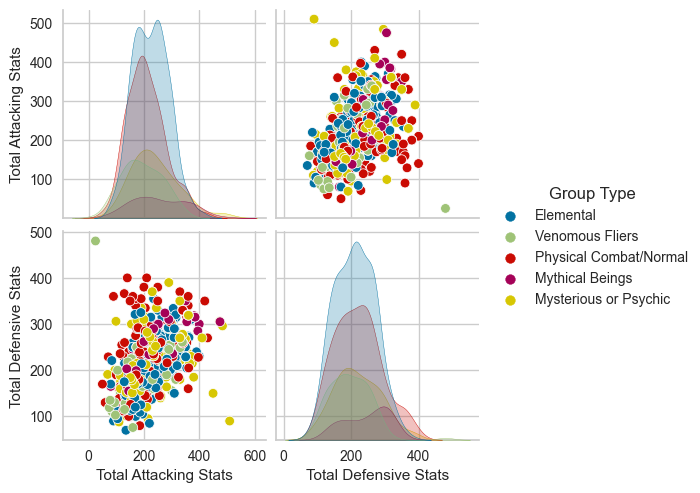

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
colors = ["red", "blue", "green", "orange", "purple", "black"]
To_Plot = [ "Total Attacking Stats", "Total Defensive Stats", "Group Type"]
plt.figure()
sns.pairplot(data[To_Plot], hue= "Group Type")
plt.show() 
#I decided to keep, despite Mr.Jerković's general recommendation to use markdowns instead of comments, 
#the "coded" comments in these two cells (this one and the one below) because I think that they are  
#a better fit in this case.
#This plot says that:
#a) Venomous Fliers are the most likely group type to have low stats.
#b) Elementals' stats are usually balanced.
#c) Mysterious or Psychic Pokemon usually have low defensive stats. Some do not, but the majority of Pokemon
#of this group type have low defensive and high attacking stats.
#d) Physical Combat/Normal Pokemon are more likely to be defensive.
#e) Mythical Beings are likely to have all-around high stats because of Dragons.

Relative Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

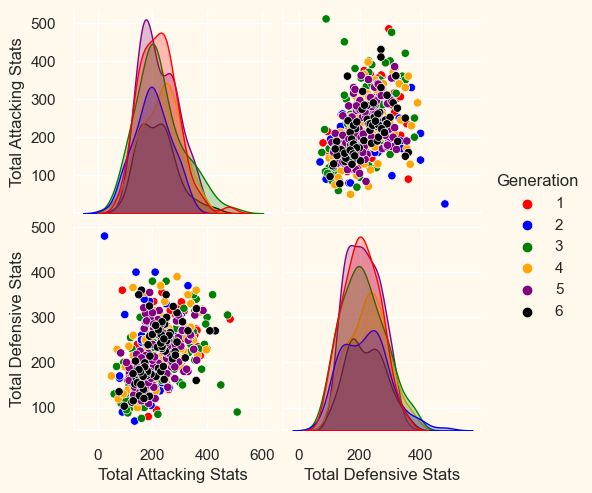

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Setting up colors preferences
colors = ["red", "blue", "green", "orange", "purple", "black"]
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = sns.color_palette(colors)

# Plotting following features
to_plot = ["Total Attacking Stats", "Total Defensive Stats", "Generation"]
print("Relative Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[to_plot], hue="Generation", palette=colors)
plt.show()
#This plot says that the later generations have more Pokemon than the earlier generations, and that, in general, 
#belonging to a specific generation does not affect a Pokemon's stats.

I made the following two plots only with two instead of three stats which make up my Total Attacking and Defensive groups 
to see how it would look like when checking Generations and Group Types against individual stats. However, I much prefer
the above plots (with the combined stats) in the case of this data set. 

Relative Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

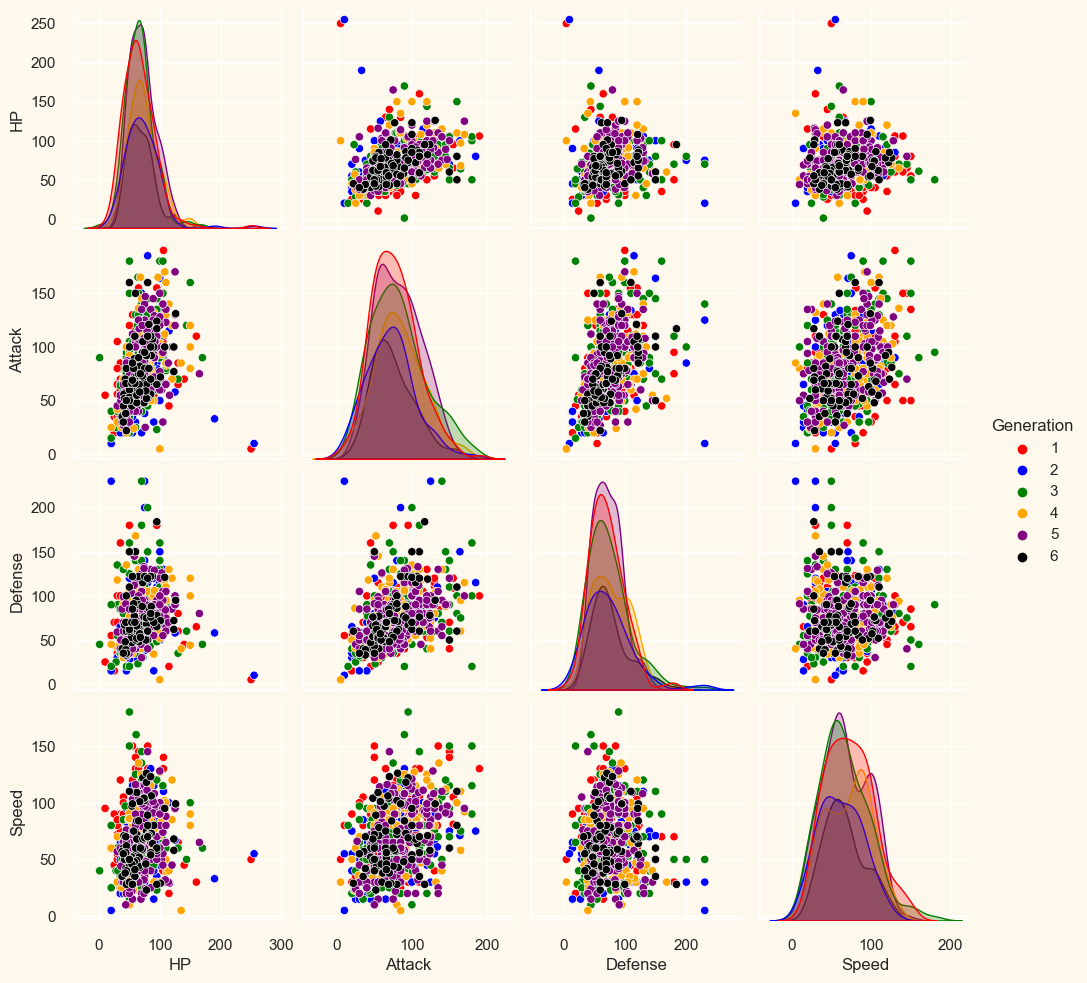

In [13]:
# Generate a color palette with a unique color for each type

colors = ["red", "blue", "green", "orange", "purple", "black"]

# Plotting following features
To_Plot = ["HP", "Attack", "Defense", "Speed", "Generation"]
print("Relative Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue="Generation", palette= colors)
plt.show()

Relative Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

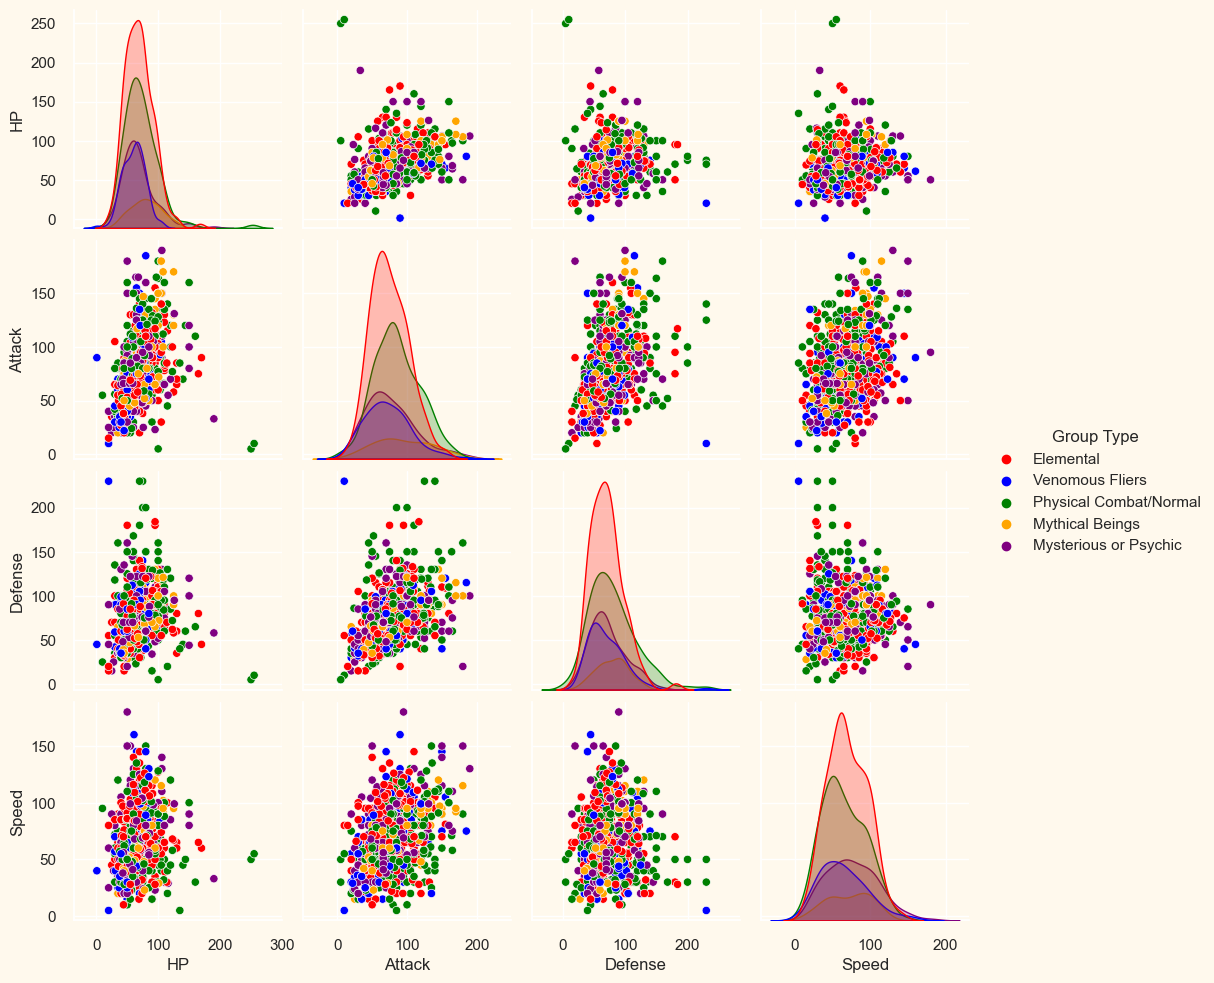

In [14]:
# Generate a color palette with a unique color for each type

colors = ["red", "blue", "green", "orange", "purple", "black"]

# Plotting following features
To_Plot = ["HP", "Attack", "Defense", "Speed", "Group Type"]
print("Relative Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue="Group Type", palette= colors)
plt.show()

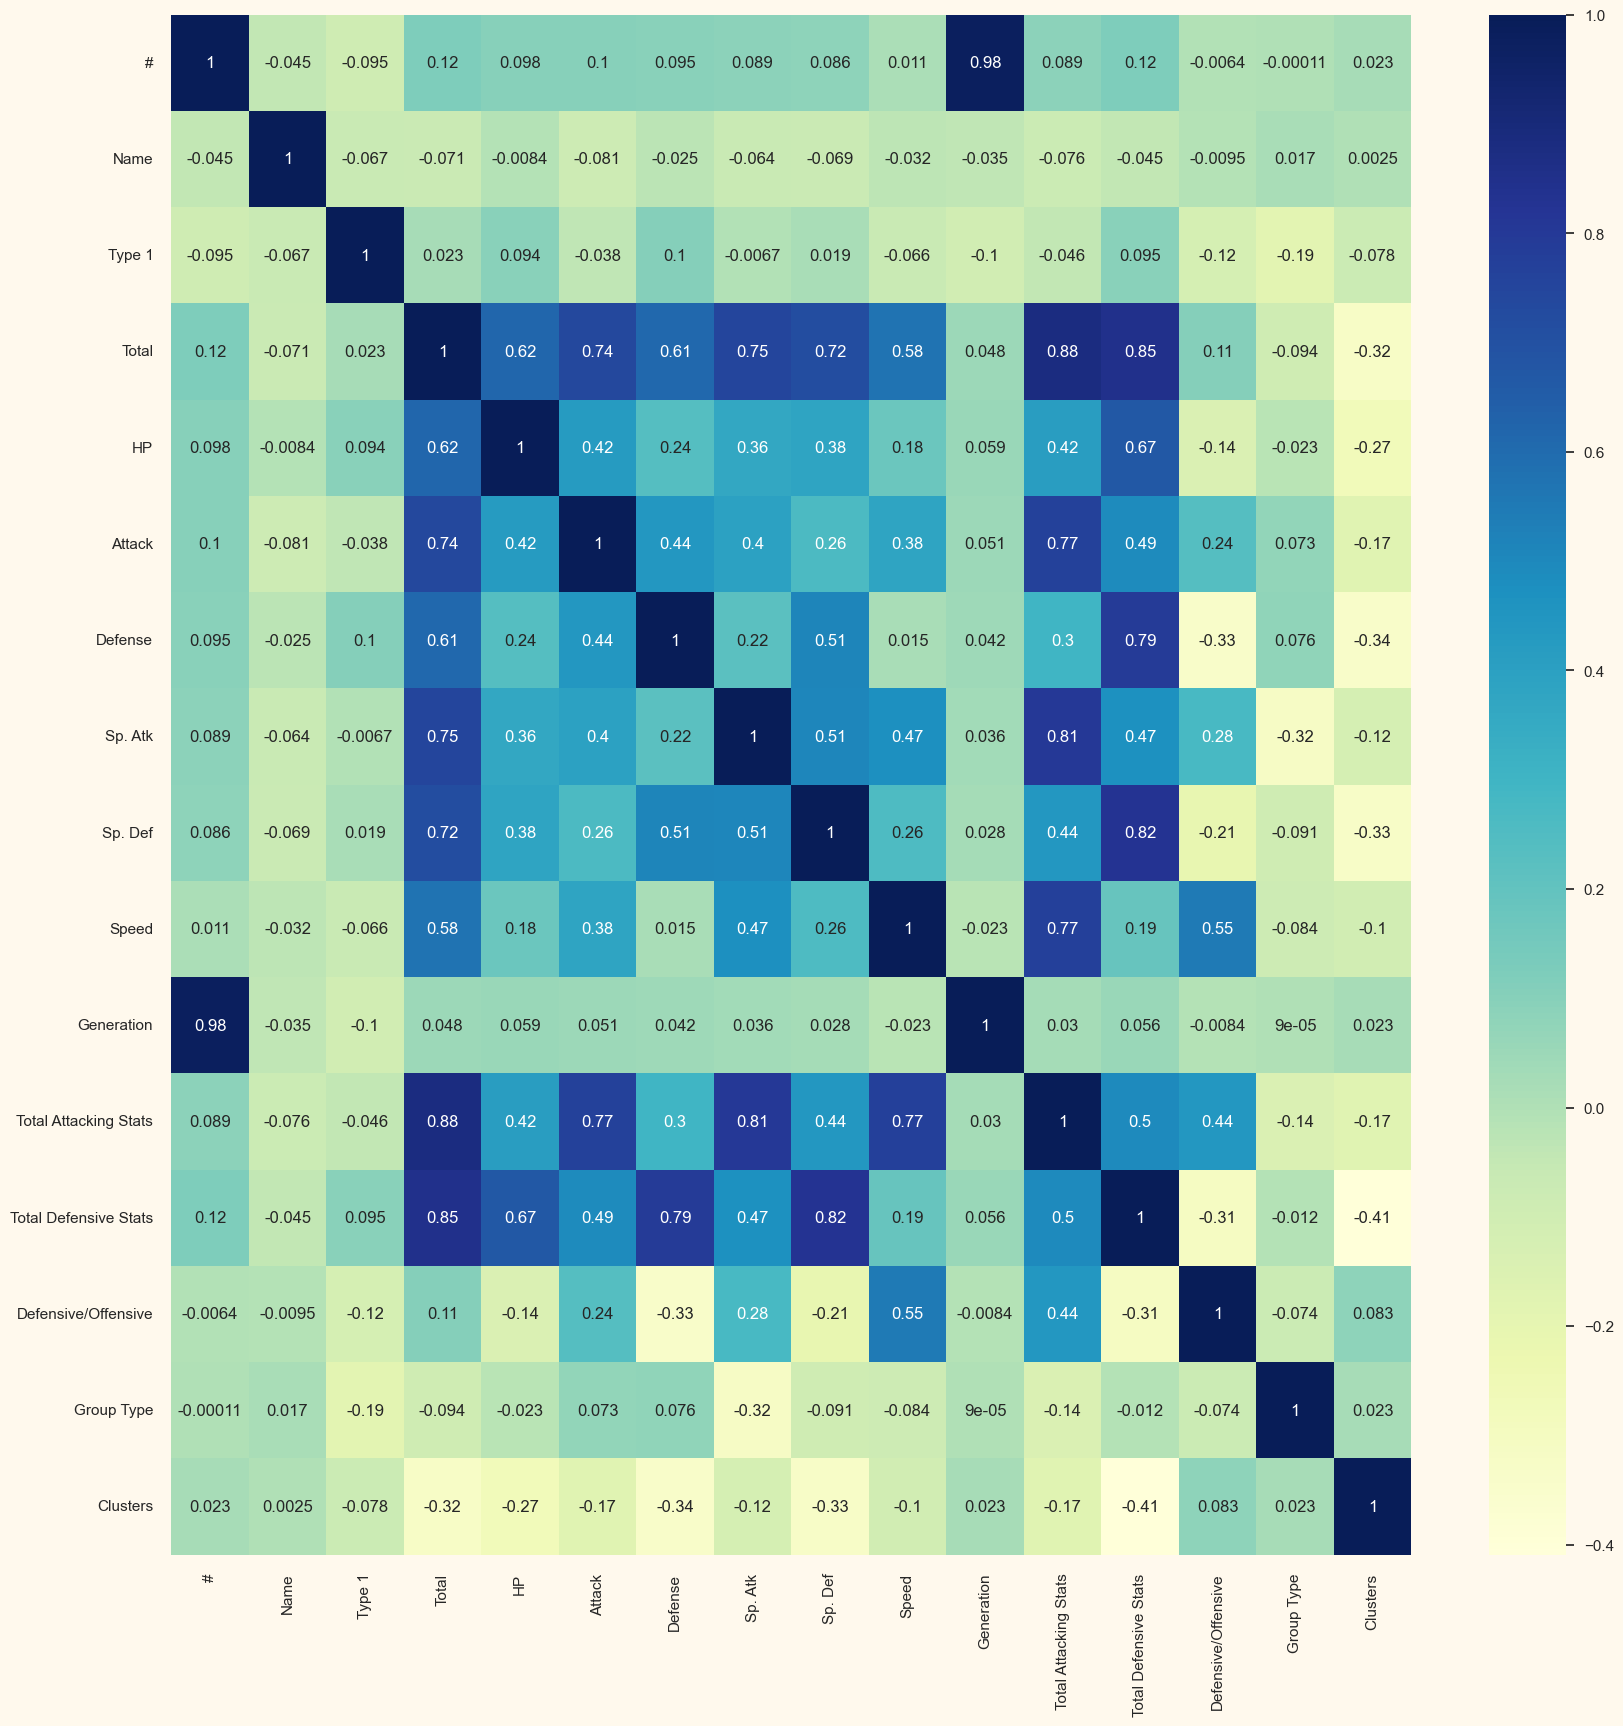

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

corrmat = data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corrmat, annot=True, cmap="YlGnBu")
plt.show()
#See below for a detailed explanation.

I'll admit that there are some useless correlations on here, like the number (#), in the data frame can be ignored, just
like the name and total stats. Also, there are some obvious and useless correlations too like 
for example, defense and total defensive stats.
However, we have already established that belonging to a specific generation does not affect a Pokemon's stats, and now
we can see that it does not affect a Pokemon's group type either. And there are some obvious but useful correlations like
the relationship between the power of Special Attacks and Total Attacking stats and the Special Defense and Total Defensive stats.
Also, the clusters are here even though they shouldn't be - but I ran the notebook multiple times to check
everything inside of it. Perhaps it is down to those reruns of the code.

## Data Preprocessing

In [16]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Creating an example dataset with two features
x = np.array([[10, 20], [30, 40], [50, 60]])
x

array([[10, 20],
       [30, 40],
       [50, 60]])

In [17]:

# Creating an instance of the StandardScaler
scaler = StandardScaler()

# Fitting and transforming the dataset using the StandardScaler
x_scaled = scaler.fit_transform(x)

print(x_scaled)

[[-1.22474487 -1.22474487]
 [ 0.          0.        ]
 [ 1.22474487  1.22474487]]


In [18]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Name', 'Type 1', 'Defensive/Offensive', 'Group Type']


In [19]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
from sklearn.preprocessing import LabelEncoder
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [20]:
#Creating a copy of data
ds = data.copy()
#Scaling
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['#', 'Name']
ds = ds.drop(cols_del, axis=1)
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [21]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Type 1,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Total Attacking Stats,Total Defensive Stats,Defensive/Offensive,Group Type
0,-0.083828,-0.976765,-0.950626,-0.924906,-0.797154,-0.239130,-0.248189,-0.801503,-1.399637,-0.829707,-0.864165,-0.059175,-1.072959
1,-0.083828,-0.251088,-0.362822,-0.524130,-0.347917,0.219560,0.291156,-0.285015,-1.399637,-0.245777,-0.185224,-1.088303,-1.072959
2,-0.083828,0.749845,0.420917,0.092448,0.293849,0.831146,1.010283,0.403635,-1.399637,0.569010,0.740606,-1.088303,-1.072959
3,-0.083828,1.583957,0.420917,0.647369,1.577381,1.503891,1.729409,0.403635,-1.399637,1.112201,1.666435,-1.088303,-1.072959
4,-0.621765,-1.051836,-1.185748,-0.832419,-0.989683,-0.392027,-0.787533,-0.112853,-1.399637,-0.585271,-1.280788,0.969953,-1.072959


## Dimensionality reduction

In [22]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,800.0,7.105427e-17,2.288764,-4.801806,-2.005763,0.231148,1.470196,6.607648
col2,800.0,-1.998401e-17,1.511209,-5.528171,-1.229905,-0.197226,1.184197,7.013787
col3,800.0,8.881784e-17,1.136027,-2.372645,-0.912975,0.058402,0.773300,3.064576


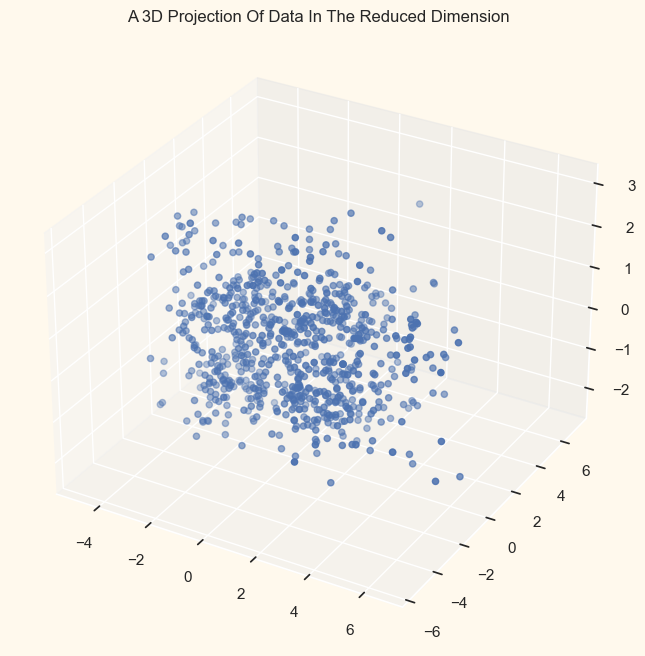

In [23]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

## Clustering

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Generate random data
X = np.random.rand(100, 2)
X

array([[0.26520237, 0.24398964],
       [0.97301055, 0.39309772],
       [0.89204656, 0.63113863],
       [0.7948113 , 0.50263709],
       [0.57690388, 0.49251769],
       [0.19524299, 0.72245212],
       [0.28077236, 0.02431597],
       [0.6454723 , 0.17711068],
       [0.94045858, 0.95392858],
       [0.91486439, 0.3701587 ],
       [0.01545662, 0.92831856],
       [0.42818415, 0.96665482],
       [0.96361998, 0.85300946],
       [0.29444889, 0.38509773],
       [0.85113667, 0.31692201],
       [0.16949275, 0.55680126],
       [0.93615477, 0.6960298 ],
       [0.57006117, 0.09717649],
       [0.61500723, 0.99005385],
       [0.14008402, 0.51832965],
       [0.87737307, 0.74076862],
       [0.69701574, 0.70248408],
       [0.35949115, 0.29359184],
       [0.80936116, 0.81011339],
       [0.86707232, 0.91324055],
       [0.5113424 , 0.50151629],
       [0.79829518, 0.64996393],
       [0.70196688, 0.79579267],
       [0.89000534, 0.33799516],
       [0.37558295, 0.09398194],
       [0.

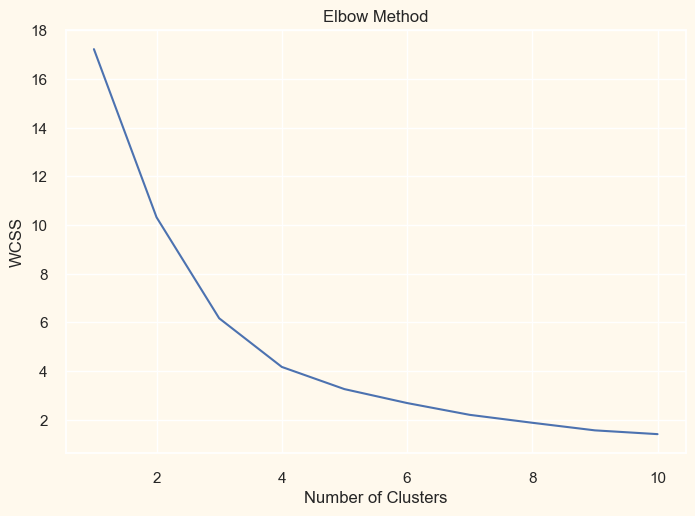

In [25]:

# Create a list to store WCSS values for each k
wcss = []

# Iterate over a range of k values
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Elbow Method to determine the number of clusters to be formed:


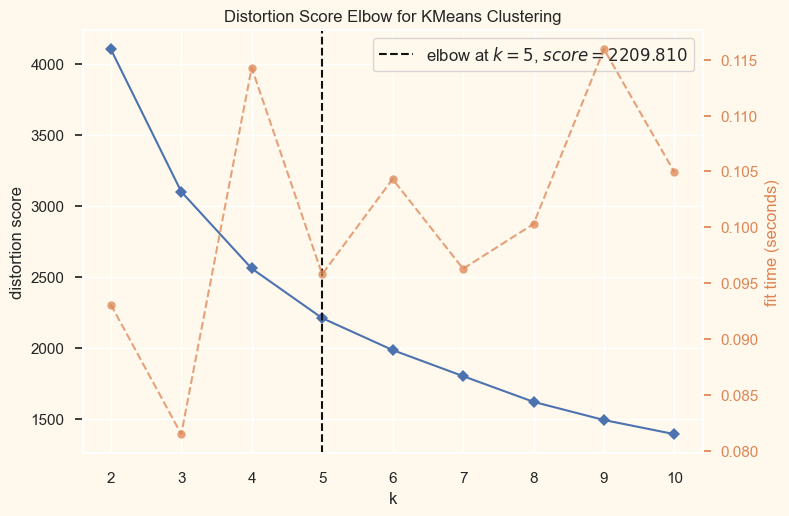

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [27]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=5)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

In [28]:
data

,#,Name,Type 1,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Total Attacking Stats,Total Defensive Stats,Defensive/Offensive,Group Type,Clusters
0,1,80,9,318,45,49,49,65,65,45,1,159,159,1,0,2
1,2,329,9,405,60,62,63,80,80,60,1,202,203,0,0,0
2,3,745,9,525,80,82,83,100,100,80,1,262,263,0,0,0
3,3,746,9,625,80,100,123,122,120,80,1,302,323,0,0,3
4,4,102,6,309,39,52,43,60,50,65,1,177,132,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,160,15,600,50,100,150,100,150,50,6,250,350,0,3,0
796,719,161,15,700,50,160,110,160,110,110,6,430,270,2,3,3
797,720,314,14,600,80,110,60,150,130,70,6,330,270,2,1,3
798,720,315,14,680,80,160,60,170,130,80,6,410,270,2,1,3


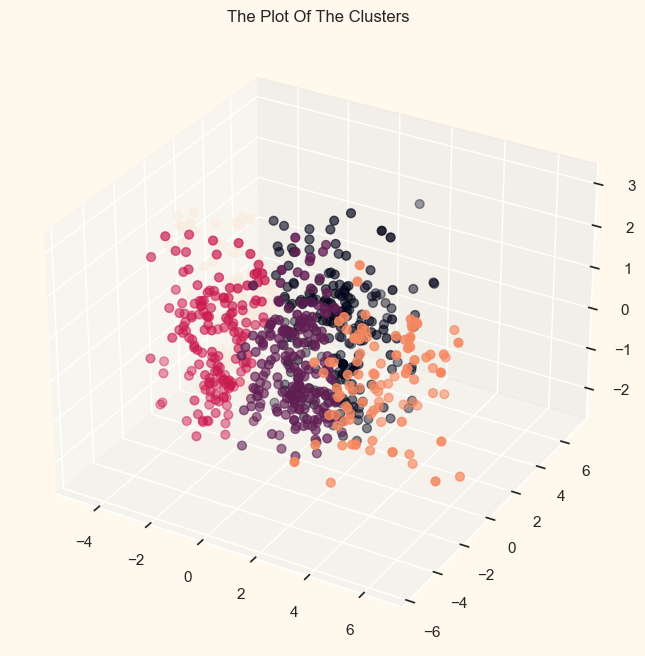

In [29]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o')
ax.set_title("The Plot Of The Clusters")
plt.show()

## Model Evaluation and Profiling

Here (especially for the profiling part) I used 
the plots which I found to be more appropriate for my data set rather than the ones from the example task.

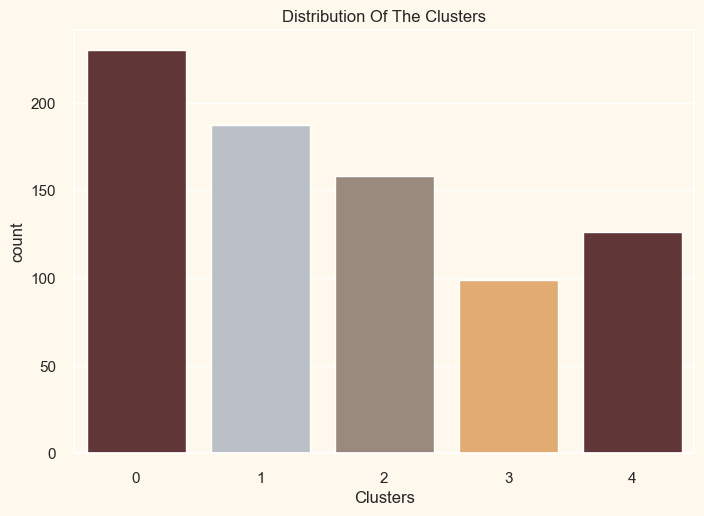

In [30]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

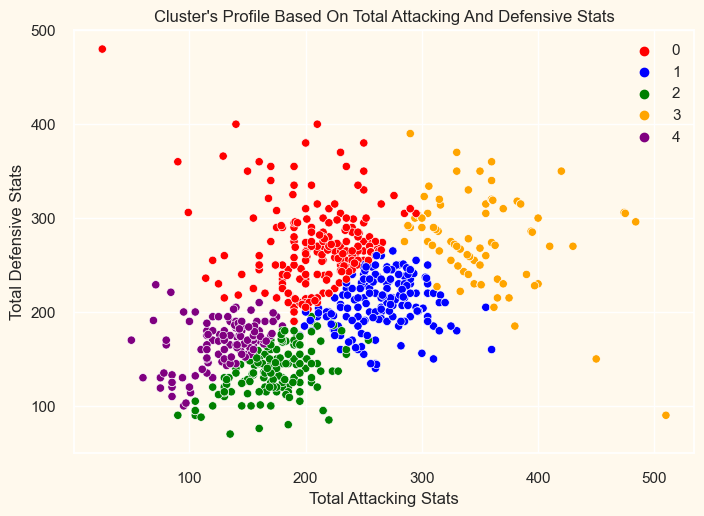

In [31]:
colors = ["red", "blue", "green", "orange", "purple"]
pl = sns.scatterplot(data=data, x="Total Attacking Stats", y="Total Defensive Stats", hue="Clusters", palette=colors)
pl.set_title("Cluster's Profile Based On Total Attacking And Defensive Stats")
plt.legend()
plt.show()

Below I made the each row have a maximum value of 1 and made that distribute accordingly across the six fields of each row.

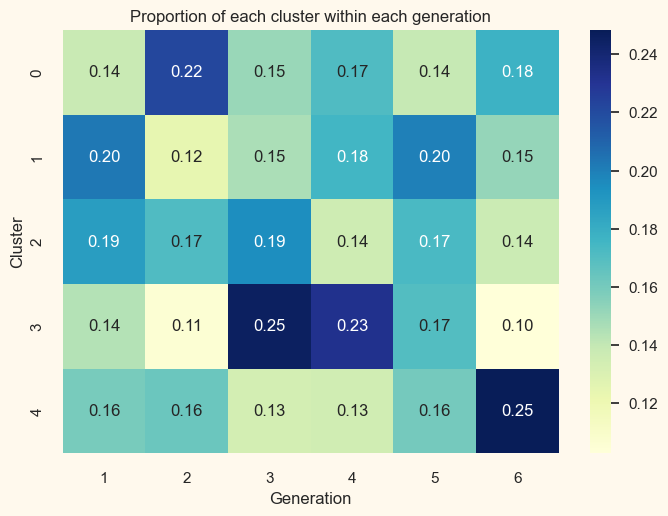

In [32]:
cluster_counts = pd.crosstab(data["Clusters"], data["Generation"])
cluster_proportions = cluster_counts.div(cluster_counts.sum(axis=0), axis=1)

for cluster in cluster_proportions.index:
    row_sum = cluster_proportions.loc[cluster].sum()
    cluster_proportions.loc[cluster] = cluster_proportions.loc[cluster] / row_sum

plt.figure()
sns.heatmap(cluster_proportions, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Proportion of each cluster within each generation")
plt.xlabel("Generation")
plt.ylabel("Cluster")
plt.show()

Below I also made the each row have a maximum value of 1 and made that distribute accordingly across the five fields of each row. I did something else too: loaded the data for the Group Type from the scaled data frame and the names
of the Group Type from the unscaled csv file so that text can be displayed for each Group Type instead of a number.

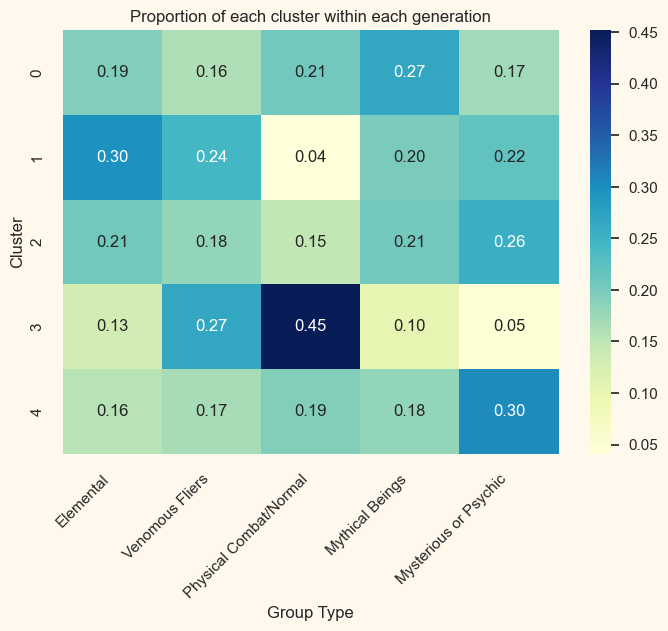

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data2 = pd.read_csv("pokemon_2.csv")

cluster_counts = pd.crosstab(data["Clusters"], data["Group Type"])
cluster_proportions = cluster_counts.div(cluster_counts.sum(axis=0), axis=1)

for cluster in cluster_proportions.index:
    row_sum = cluster_proportions.loc[cluster].sum()
    cluster_proportions.loc[cluster] = cluster_proportions.loc[cluster] / row_sum

plt.figure()
heatmap = sns.heatmap(cluster_proportions, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Proportion of each cluster within each generation")
plt.xlabel("Group Type")
plt.ylabel("Cluster")
heatmap.set_xticklabels(data2["Group Type"].unique(), rotation=45, ha="right")
plt.show()

Profiling of the Pokemon in different clusters

Cluster 0:
Pokemon in this cluster are likely to have middlle-of-the-road stats which slightly lean on the defensive side,
most likely(0.22 was the highest value) belong to the second generation and the Mythical Beings group type (Dragon, Fairy).

Cluster 1:
Pokemon in this cluster are also likely to have middle-of-the-road stats, but unlike in the cluster zero, their stats
lean slightly more on the attacking side. They are most likely to belong to either the first or the fifth generation (0.20 
for both) and be of the Elemental group type (Fire, Water, Grass, Electric, Ice).

Cluster 2:
Are likely to have low stats which lean on the attacking side, 
be of the first or third generation and of the Mysterious or Psychic group type (Ghost, Dark, Psychic).

Cluster 3:
Are likely to have high stats which lean on the attacking side, belong to the thrid (0.25) or fourth (0.23) generation, and be
of the Physical Combat/Normal group type (Normal, Fighting, Ground, Rock, Steel). 
Also, this correlation of 0.45 is the highest correlation between a cluster and a type.

Cluster 4:
Are likely to have low stats which lean on the defensive side, belong to the sixth generation and be of the 
Mysterious and Psychic (Ghost, Dark, Psychic) type.

I also noticed that my clusters' profiles describe them well, but that the individual points inside
of them don't seem to correlate with one another. I think that this may be a good point for further discussion.